In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
# Hücre 1: Gerekli Kütüphaneler ve Değişkenler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # Görüntüleri okumak ve işlemek için OpenCV kütüphanesi

# Kaggle'daki veri seti klasör yapısını tanımladım.
base_dir = '../input/brain-tumor-mri-dataset/'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Eğitim klasöründeki alt klasörleri okuyarak sınıf isimlerimi belirledim.
# Bunlar benim etiketlerim olacak: 'glioma', 'meningioma', 'notumor', 'pituitary'
class_names = sorted(os.listdir(train_dir))
print("Sınıflar:", class_names)
print("Toplam sınıf sayısı:", len(class_names))

Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']
Toplam sınıf sayısı: 4


Eğitim setindeki her sınıfa ait görsel sayıları:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


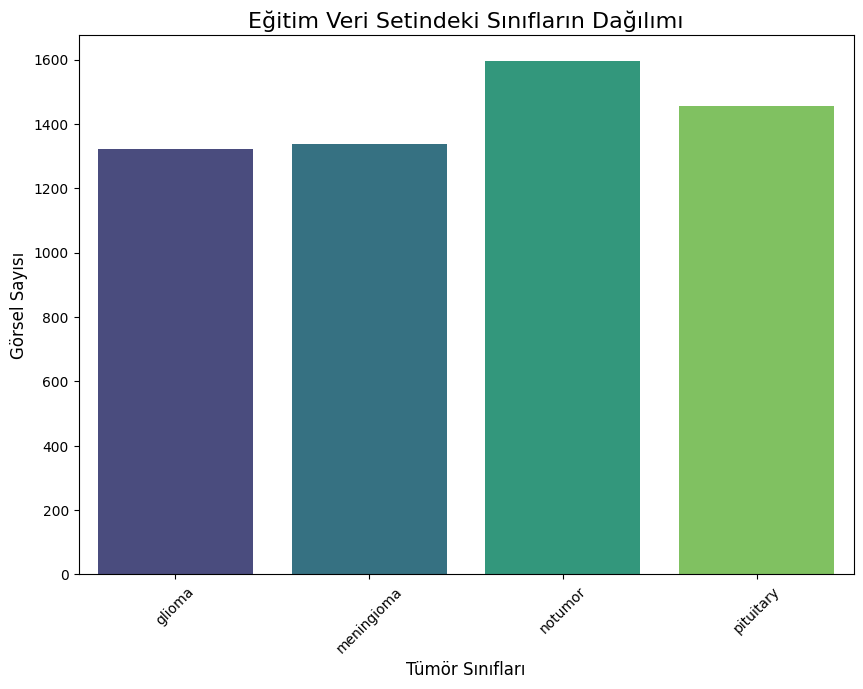

In [3]:
# Hücre 2: Sınıf Dağılımının Hesaplanması ve Görselleştirilmesi
# Eğitim setindeki her bir sınıfta kaç adet görüntü olduğunu saydım.
class_distribution = {}
for cls in class_names:
    class_path = os.path.join(train_dir, cls)
    # Klasördeki dosya sayısını sayarak sözlüğüme ekledim.
    num_images = len(os.listdir(class_path))
    class_distribution[cls] = num_images

print("Eğitim setindeki her sınıfa ait görsel sayıları:")
print(class_distribution)

# Bu dağılımı bir bar grafiği ile görselleştirdim.
plt.figure(figsize=(10, 7))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette='viridis')
plt.title('Eğitim Veri Setindeki Sınıfların Dağılımı', fontsize=16)
plt.xlabel('Tümör Sınıfları', fontsize=12)
plt.ylabel('Görsel Sayısı', fontsize=12)
plt.xticks(rotation=45)
plt.show()

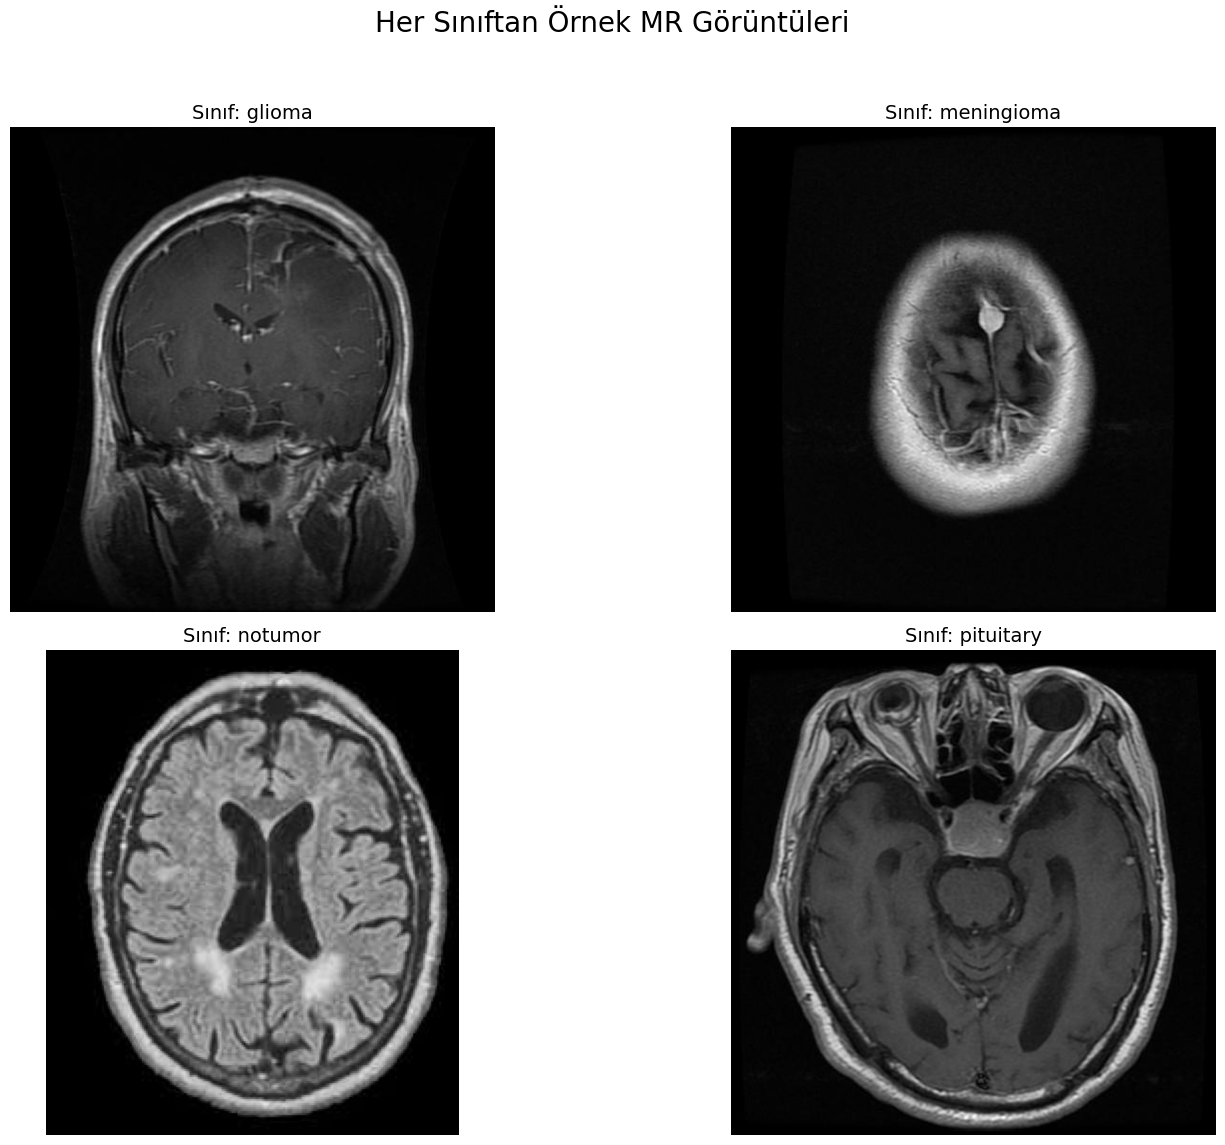

In [4]:
# Hücre 3: Her Sınıftan Örnek Görsellerin Gösterimi
# 2x2'lik bir çizim alanı oluşturdum.
plt.figure(figsize=(16, 12))

for i, cls in enumerate(class_names):
    plt.subplot(2, 2, i + 1)
    
    # İlgili sınıfın klasör yolunu belirledim.
    class_path = os.path.join(train_dir, cls)
    # Klasörden rastgele bir görüntü adı seçtim.
    random_image_name = np.random.choice(os.listdir(class_path))
    
    # Görüntüyü OpenCV ile okudum.
    img = cv2.imread(os.path.join(class_path, random_image_name))
    
    # Görüntüyü doğru renklerde gösterebilmek için BGR'dan RGB'ye çevirdim.
    # HATA BURADAYDI: cv -> cv2 olarak düzeltildi
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f'Sınıf: {cls}', fontsize=14)
    plt.axis('off')

plt.suptitle('Her Sınıftan Örnek MR Görüntüleri', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Piksel değerlerini 0-1 arasına çekmek (normalize etmek) için rescale kullandım.
# Ayrıca eğitim setini zenginleştirmek için çeşitli veri artırma teknikleri ekledim.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Görüntüleri rastgele 20 dereceye kadar döndür
    width_shift_range=0.1,  # Genişlikte %10'a kadar kaydır
    height_shift_range=0.1, # Yükseklikte %10'a kadar kaydır
    shear_range=0.1,        # Eğme/Bükme uygula
    zoom_range=0.1,         # %10'a kadar rastgele yakınlaştır
    horizontal_flip=True,   # Yatayda rastgele çevir
    fill_mode='nearest',    # Oluşan boşlukları en yakın pikselle doldur
    validation_split=0.2    # Veri setinin %20'sini doğrulama için ayır
)

# Doğrulama ve test verileri için sadece piksel normalizasyonu yapıyorum.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2    # Aynı oranda ayırarak aynı verilerin seçilmesini sağlıyorum
)

print("ImageDataGenerator'lar başarıyla oluşturuldu.")

2025-09-26 19:21:31.453770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758914491.662645      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758914491.721304      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ImageDataGenerator'lar başarıyla oluşturuldu.


In [6]:
# Eğitim verilerini 'Training' klasöründen okuyacak üreteci oluşturuyorum.
train_generator = train_datagen.flow_from_directory(
    train_dir,                  # Eğitim görsellerinin olduğu ana klasör
    target_size=(150, 150),     # Tüm görselleri 150x150 piksele yeniden boyutlandır
    batch_size=32,              # Her adımda modele 32 görsel ver
    class_mode='categorical',   # Sınıflandırma türü (çok sınıflı olduğu için)
    subset='training'           # Bu üretecin eğitim setini kullanacağını belirtiyorum
)

# Doğrulama verilerini 'Training' klasöründen okuyacak üreteci oluşturuyorum.
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'         # Bu üretecin doğrulama setini kullanacağını belirtiyorum
)

print("\nEğitim ve Doğrulama üreteçleri hazır!")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.

Eğitim ve Doğrulama üreteçleri hazır!


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Modelimi Sequential API kullanarak katman katman oluşturuyorum.
model = Sequential([
    # 1. Convolutional Blok
    # 150x150 boyutunda 3 kanallı (RGB) bir görüntü girdi olarak verilecek.
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    
    # 2. Convolutional Blok
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # 3. Convolutional Blok
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Özellik haritalarını tek boyutlu vektöre çevirme
    Flatten(),
    
    # Yoğun (Dense) Katman ve Dropout
    Dense(512, activation='relu'),
    Dropout(0.5), # Nöronların %50'sini rastgele kapatarak ezberlemeyi önler
    
    # Çıktı Katmanı
    # 4 sınıfımız olduğu için 4 nöron ve çok sınıflı sınıflandırma için 'softmax'
    Dense(4, activation='softmax')
])

# Modelin mimarisini ve parametre sayısını görmek için bir özet yazdırıyorum.
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-26 19:21:45.397884: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model başarıyla derlendi ve eğitime hazır.")

Model başarıyla derlendi ve eğitime hazır.


In [ ]:
# Modeli kaç epoch (tur) eğiteceğimizi belirliyoruz.
EPOCHS = 25

# Eğitim sürecini başlatıyoruz.
# Bu fonksiyon, tüm eğitim geçmişini 'history' adlı bir değişkene kaydedecek.
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

print("\nModelin eğitimi başarıyla tamamlandı.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.4926 - loss: 1.1557 - val_accuracy: 0.7125 - val_loss: 1.1298
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7303 - loss: 0.6773 - val_accuracy: 0.6275 - val_loss: 1.2921
Epoch 3/25
104/143 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7785 - loss: 0.5354

In [ ]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden metrikleri alıyoruz
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Toplam epoch sayısını alıyoruz
epochs_range = range(len(acc))

# Grafik için bir alan oluşturuyoruz (1 satır, 2 sütun)
plt.figure(figsize=(16, 7))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Accuracy)')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Accuracy)')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# Test veri üreteci için sadece piksel normalizasyonu yapıyorum
test_datagen = ImageDataGenerator(rescale=1./255)

# 'Testing' klasöründen verileri okuyacak üreteci oluşturuyorum
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Çok önemli: Tahminlerin sırasının bozulmaması için karıştırmayı kapatıyoruz
)

In [ ]:
import numpy as np

# Modelin test seti üzerindeki tahminlerini alıyorum
predictions = model.predict(test_generator)

# Modelin çıktıları olasılık değerleridir. En yüksek olasılığa sahip sınıfı
# (indeksi) nihai tahmin olarak almak için np.argmax kullanıyorum.
predicted_classes = np.argmax(predictions, axis=1)

# Gerçek (doğru) etiketleri de test_generator'dan alıyorum
true_classes = test_generator.classes

# Sınıf isimlerini alıyorum
class_labels = list(test_generator.class_indices.keys())

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Karmaşıklık matrisini oluşturuyorum
cm = confusion_matrix(true_classes, predicted_classes)

# Matrisi daha anlaşılır olması için görselleştiriyorum
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.title('Karmaşıklık Matrisi (Confusion Matrix)')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Sınıflandırma raporunu yazdırıyorum
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Sınıflandırma Raporu:\n")
print(report)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

def get_img_array(img_path, size):
    # Görüntüyü yükler ve modele uygun boyuta getirir
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # Görüntüyü bir numpy dizisine çevirir
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Modelin tek bir görüntü üzerinde çalışabilmesi için boyut ekler
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Girdi ve son evrişimli katmanın çıktılarını alan bir model oluşturur
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Görüntüye göre gradyanları hesaplar
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradyanları alır
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Isı haritasını oluşturur
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizasyon
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_gradcam(img_path, heatmap, alpha=0.4):
    # Orijinal görüntüyü yükler
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Renkleri düzelt

    # Isı haritasını yeniden boyutlandırır
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Isı haritasını orijinal görüntüyle birleştirir
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img

print("Grad-CAM fonksiyonları hazırlandı.")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Gerekli Fonksiyonlar ---
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

# --- Grad-CAM Uygulaması ---

# Sınıf etiketlerini ve test dizinini tanımla
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
test_dir = '../input/brain-tumor-mri-dataset/Testing'

# Rastgele bir test görüntüsü seç
random_class = np.random.choice(class_labels)
random_class_dir = os.path.join(test_dir, random_class)
if os.path.exists(random_class_dir) and len(os.listdir(random_class_dir)) > 0:
    img_name = np.random.choice(os.listdir(random_class_dir))
    img_path = os.path.join(random_class_dir, img_name)
    
    # Görüntüyü modele uygun hale getir
    img_size = (150, 150)
    img_array = get_img_array(img_path, size=img_size) / 255.0

    # Son evrişimli katmanın ismini bul
    last_conv_layer_name = ""
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer_name = layer.name
            break
    
    # --- SİZİN ÖNERDİĞİNİZ AKILLICA ÇÖZÜM ---
    # Modeli ilk kez burada çağırarak "build" işlemini garantiliyoruz
    # ve sonucu daha sonra kullanmak üzere saklıyoruz.
    preds = model.predict(img_array)
    
    # Tahmin sonuçlarını işle
    predicted_class_index = np.argmax(preds)
    predicted_class_name = class_labels[predicted_class_index]
    print(f"Seçilen Görüntü Sınıfı: {random_class}")
    print(f"Modelin Tahmini: {predicted_class_name} (Olasılık: {preds[0][predicted_class_index]:.4f})")
    
    # Isı haritasını oluştur
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed_img = superimpose_gradcam(img_path, heatmap)

    # Sonuçları göster
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.resize(cv2.imread(img_path), img_size))
    plt.title(f"Orijinal Görüntü ({random_class})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.resize(superimposed_img, img_size))
    plt.title(f"Grad-CAM (Tahmin: {predicted_class_name})")
    plt.axis('off')

    plt.show()
else:
    print(f"'{random_class}' klasöründe görüntü bulunamadı veya klasör yok.")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# --- 1. MODELİ YENİ DROPOUT ORANI İLE OLUŞTURMA ---
print("Model, Dropout(0.3) ile yeniden oluşturuluyor...")

# Girdi katmanını tanımla
inputs = Input(shape=(150, 150, 3))

# Katmanları birbirine bağla
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# --- DEĞİŞİKLİK BURADA ---
x = Dropout(0.3)(x) # Dropout oranını 0.5'ten 0.3'e düşürdük.

outputs = Dense(4, activation='softmax')(x)

# Yeni modeli oluştur
new_model = Model(inputs, outputs)

print("Model başarıyla oluşturuldu.")

# --- 2. YENİ MODELİ DERLEME ---
print("\nYeni model derleniyor...")
new_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model derlendi.")

# --- 3. YENİ MODELİ EĞİTME ---
print("\nYeni model eğitiliyor...")
# Not: train_generator ve validation_generator'ın daha önceki adımlarda
# oluşturulduğunu varsayıyoruz. Eğer hata alırsanız, önceki veri
# hazırlama hücrelerini yeniden çalıştırmanız gerekebilir.
new_history = new_model.fit(
    train_generator,
    epochs=25, # İlk modelle aynı epoch sayısında eğitiyoruz
    validation_data=validation_generator,
    verbose=1
)
print("Yeni modelin eğitimi tamamlandı.")

# --- 4. YENİ SONUÇLARI GÖRSELLEŞTİRME ---
print("\nYeni sonuçlar görselleştiriliyor...")
acc = new_history.history['accuracy']
val_acc = new_history.history['val_accuracy']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 7))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Dropout=0.3 ile Eğitim ve Doğrulama Doğruluğu')

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Dropout=0.3 ile Eğitim ve Doğrulama Kaybı')

plt.show()